In [95]:
!pip3 install pin meshcat

In [96]:
#
# In this short script, we show how to use RobotWrapper
# integrating different kinds of viewers
#
 
import pinocchio as pin
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.visualize import GepettoVisualizer, MeshcatVisualizer
from sys import argv
import os
from os.path import dirname, join, abspath
from time import sleep
import numpy as np
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt


In [97]:

VISUALIZER = MeshcatVisualizer

# IK params
IK_EPS = 1e-5
IK_IT_MAX = 300
IK_DT = 1e-1
IK_DAMP = 1e-12
 
# Torque error from data
TORQUE_ERROR = 0.25

# Load the URDF model with RobotWrapper
# Conversion with str seems to be necessary when executing this file with ipython
pinocchio_model_dir = join(abspath(''), "models")
 
model_path = join(pinocchio_model_dir, "example-robot-data/robots")
mesh_dir = pinocchio_model_dir
urdf_filename = "z1.urdf"
urdf_model_path = join(join(model_path, "z1_description/urdf"), urdf_filename)
 
robot = RobotWrapper.BuildFromURDF(urdf_model_path, mesh_dir)
 
# alias
model = robot.model
data = robot.data

# Get end-effector id
ee_frame_id = model.getFrameId("link06")
world_frame_id = model.getFrameId("world")
ee_joint_id = model.getFrameId("joint6")
print(f"End-effectors id: {ee_frame_id}")
 
# do whatever, e.g. compute the center of mass position expressed in the world frame
q = robot.q0
 
# Show model with a visualizer of your choice
if VISUALIZER:
    robot.setVisualizer(VISUALIZER())
    robot.initViewer()
    robot.loadViewerModel("pinocchio")
    robot.display(q)

End-effectors id: 16
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [98]:
def solve_ik(oMdes: pin.SE3, q0: np.ndarray):
    q = q0.copy()
    i = 0
    while True:
        pin.forwardKinematics(model, data, q)
        iMd = data.oMi[-1].actInv(oMdes)
        err = pin.log(iMd).vector  # in joint frame
        if norm(err) < IK_EPS:
            success = True
            break
        if i >= IK_IT_MAX:
            success = False
            break
        J = pin.computeFrameJacobian(model, data, q, ee_frame_id, pin.ReferenceFrame.WORLD)  # in joint frame
        J = -np.dot(pin.Jlog6(iMd.inverse()), J)
        v = -J.T.dot(solve(J.dot(J.T) + IK_DAMP * np.eye(6), err))
        q = pin.integrate(model, q, v * IK_DT)
        i += 1
    return success, q

In [99]:
# Specify robot force-torque estimation precizion

def ft_precision(model, data, ee_frame_id, q: np.ndarray, torque_error: np.ndarray) -> np.float64:
    J = pin.computeFrameJacobian(model, data, q, ee_frame_id, pin.ReferenceFrame.WORLD)
    binary_expansions = np.array([list(map(int, format(i, '06b'))) for i in range(64)])
    sign_combinations = 2 * binary_expansions - 1

    max_force_error = 0
    for sign_combination in sign_combinations:
        torque_combination = [sign * element for sign, element in zip(sign_combination, torque_error)]
        ft_error = np.linalg.pinv(J.T) @ torque_combination
        force_error = np.linalg.norm(ft_error[:3])
        max_force_error = max(max_force_error, force_error)

    return max_force_error

In [100]:
# Joint limits check

def check_joint_limits_gap(model, q: np.ndarray, valid_gap = 0.5) -> bool:
    lower_limits = model.lowerPositionLimit
    upper_limits = model.upperPositionLimit

    result = True
    for i in range(q.shape[0]):
        result = result and q[i] > lower_limits[i] + valid_gap and q[i] < upper_limits[i] - valid_gap
    
    return result

In [101]:
# ik solver test

q = pin.randomConfiguration(model)
J = pin.computeFrameJacobian(model, data, q, ee_frame_id, pin.ReferenceFrame.WORLD)
robot.display(q)
oMdes = pin.SE3(np.eye(3), np.array([0.3, 0.0, 0.3]))
ok, q_des = solve_ik(oMdes, q)
print(ok, q_des)

True [ 3.14162882e+00  1.27530909e-01 -6.12066902e-01 -2.65705612e+00
  3.74581558e-05 -3.14159173e+00]


In [102]:
# ft sensor test

q = pin.randomConfiguration(model)
ft = ft_precision(model, data, ee_frame_id, q, np.array([TORQUE_ERROR]*6))
robot.display(q)
print("Force error: ", ft)

Force error:  6.822377859767502


In [112]:
# First "good" position

q0 = np.array([0.,  0.8, -0.61626972, -0.58472597, -0.14236352, -1.52970918])
oMdes = pin.SE3(np.eye(3), np.array([0.35, 0.0, 0.35]))
ok, q_des = solve_ik(oMdes, q0)
J = pin.computeFrameJacobian(model, data, q_des, ee_frame_id, pin.ReferenceFrame.WORLD)
print("Q: ", q_des)
print("Jacobian condition number:", np.linalg.cond(J))
print("Joint limits check: ", check_joint_limits_gap(model, q_des))
robot.display(q_des)

ROBOT_POSE_UP = q_des

Q:  [-3.09361987e-05  1.65658207e+00 -9.30015505e-01 -7.26566632e-01
  3.02521007e-05 -2.58731027e-06]
Jacobian condition number: 11.441591688569568
Joint limits check:  True


In [122]:
# # Second "good" position

# rotation_matrix = np.array([
#     [0, -1, 0],
#     [0, 0, 1],
#     [-1, 0, 0]
# ])

# q_des = np.array([0.,  1.5, -0.61626972, 0.68472597, -0.14236352, -1.52970918])
# oMdes = pin.SE3(rotation_matrix, np.array([0.6, 0., 0.4]))

# ok, q_des = solve_ik(oMdes, q0)
# J = pin.computeFrameJacobian(model, data, q_des, ee_frame_id, pin.ReferenceFrame.WORLD)

# # pin.forwardKinematics(model, data, q_des)
# # for name, oMi in zip(model.names, data.oMi):
# #     print(name, *oMi.rotation)

# print("Q: ", q_des)
# print("Jacobian condition number:", np.linalg.cond(J))
# print("Joint limits check: ", check_joint_limits_gap(model, q_des))
# robot.display(q_des)

# ROBOT_POSE_DOWN = q_des

Q:  [ -0.50087401 -22.94550314  56.26410134  19.96309126   8.83566684
  45.61226655]
Jacobian condition number: 23.5708957323069
Joint limits check:  False


In [124]:
def get_points(model, data, ee_frame_id, x, y, z, orientation = np.eye(3), max_force = 20, show_maxs = False):
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    points = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
    point_values = []
    good_points = []
    for point in points:
        oMdes = pin.SE3(orientation, np.array(point))
        ok, q_des = solve_ik(oMdes, ROBOT_POSE_UP)
        if ok:
            force_error = ft_precision(model, data, ee_frame_id, q_des, np.array([TORQUE_ERROR]*6))
            force_error = np.clip(force_error, 0, max_force)
            
            if not show_maxs and force_error >= max_force:
                continue
            
            point_values.append(force_error)
            good_points.append(point)
           

    point_values = np.array(point_values)
    good_points = np.array(good_points)
    return good_points, point_values

In [131]:
def get_3d_plot(points, point_values):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=point_values, cmap='seismic', alpha = 0.25)
    fig.colorbar(scatter, ax=ax)
    plt.show()

In [162]:
def get_slices(points, point_values, axis = 'z'):
    id = -1
    if axis == 'z':
        id = 2
    elif axis == 'y':
        id = 1
    elif axis == 'x':
        id = 0
    else:
        raise NotImplementedError

    for sliced_value in np.unique(points[:, id]):
        fig = plt.figure()
        ax = fig.add_subplot()
        mask = points[:, 2] == sliced_value
        selected_points = points[mask]
        selected_point_values = point_values[mask]
        scatter = ax.scatter(selected_points[:, 0], selected_points[:, 1], c=selected_point_values, cmap='seismic', alpha = 0.25)
        fig.colorbar(scatter, ax=ax)
        plt.title(f"Slice, {axis} = {sliced_value}")
    plt.show()

In [159]:
X = np.linspace(0., 1., 25)
Y = np.linspace(-1., 1., 25)
Z = np.linspace(0., 1., 10)
good_points, point_values = get_points(model, data, ee_frame_id, X, Y, Z, max_force = 10)

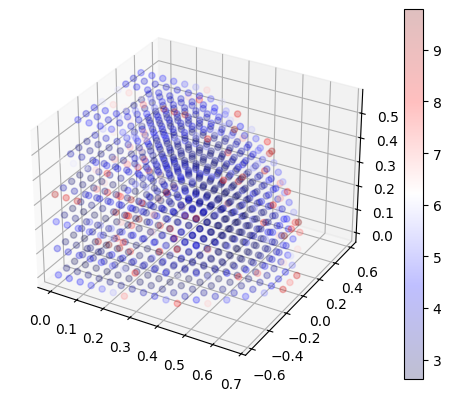

In [160]:
%matplotlib inline
get_3d_plot(good_points, point_values)

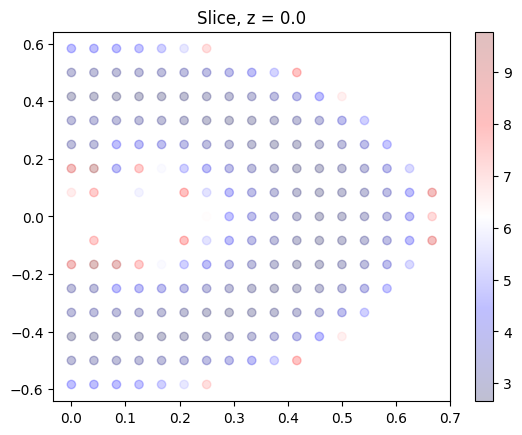

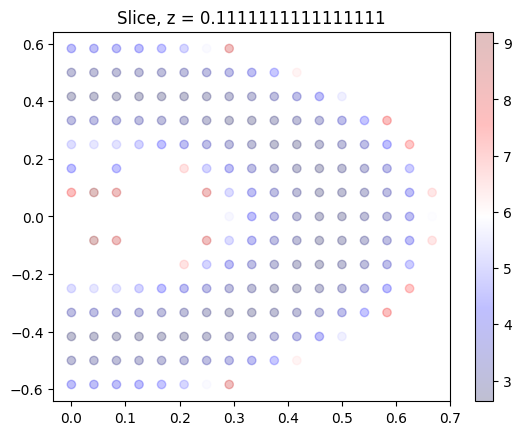

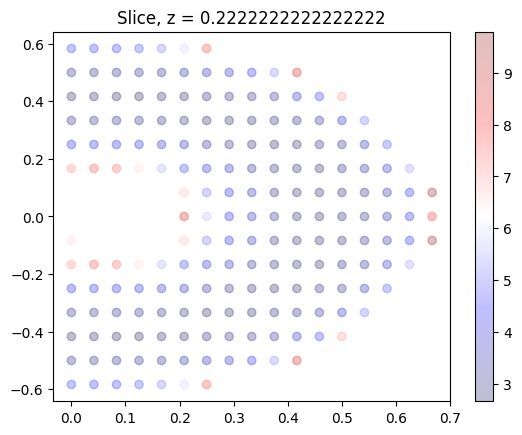

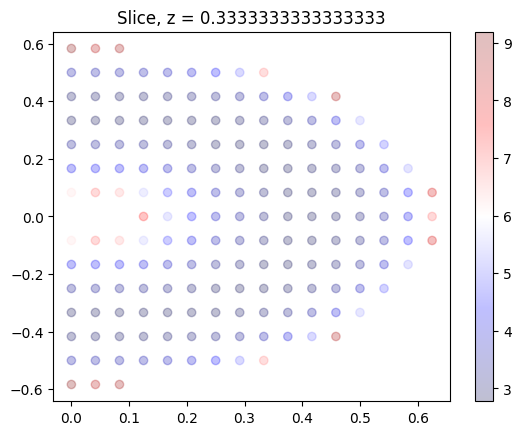

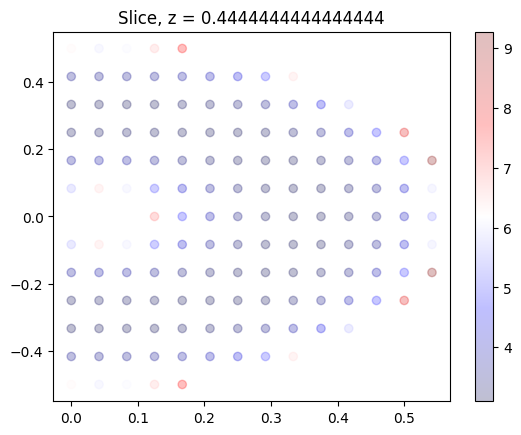

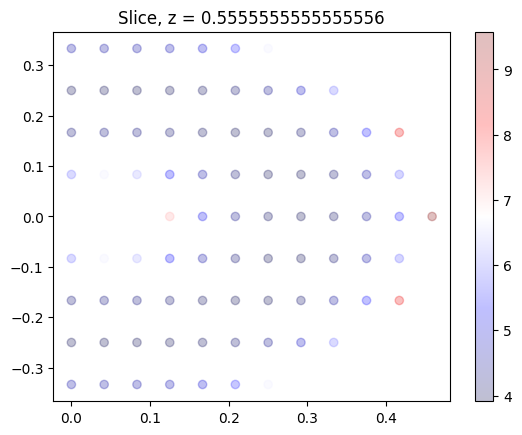

In [163]:
%matplotlib inline
get_slices(good_points, point_values)